# All imports necessary

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys

In [3]:
sys.path.append('..')

In [4]:
from source.code.utils.utils import filter_by_subcorpus
from source.code.utils.utils import get_tagged_texts_as_pd

In [5]:
from source.code.utils.preprocessing import additional_features
from source.code.utils.preprocessing import filtrations

In [6]:
import os
import numpy as np
import pandas as pd

In [7]:
import matplotlib.pyplot as plt

In [8]:
import seaborn as sns

In [9]:
from tqdm.autonotebook import tqdm

In [10]:
sns.set(color_codes=True)

In [11]:
sns.set(font_scale=2)

In [12]:
%matplotlib inline

# Read the data

## Where are we at the moment

In [13]:
! pwd

/home/bender/PycharmProjects/NLP/notebooks


In [14]:
! ls -alth ../data/datasets/gmb-2.2.0/

итого 253M
drwxrwxr-x.   4 bender bender 4,0K окт  7 16:35 ..
-rw-rw-r--.   1 bender bender 177M сен 30 15:56 en.tags.pd.extracted.csv
drwxr-x---.   4 bender bender 4,0K сен 30 15:56 .
-rw-rw-r--.   1 bender bender  76M сен 27 02:43 en.raw.extracted.npy
-rw-r-----.   1 bender bender 7,4K июл  4  2014 README
-rw-rw-r--.   1 bender bender 2,0K июл  4  2014 NEWS
-rw-r-----.   1 bender bender  497 июл  2  2014 THANKS
drwxr-x---. 102 bender bender 4,0K июл  2  2014 data
-rw-r-----.   1 bender bender  279 июн 23  2014 LICENSE
drwxr-x---.   2 bender bender 4,0K авг 21  2013 doc


## Get the subset of folders for target subcorpus (Voice of America)

In [15]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

## Read subcorpus

In [16]:
tagged_texts_as_pd = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

## Do a bit of preprocessing

Here (besides what is written on the left side of progress bars) we get rid of:
- English stop-words;
- non-numerical word sense values;
- some trash-values in NER-tag column.

In [17]:
tagged_texts_as_pd_f = filtrations(tagged_texts_as_pd)

## Add new features describing words

Here we calculate some additional features, namely:
- semantic relation word presence (binary feature);
- animacy tag presence (binary feature);
- length of Lambda-DSR expression (numeric feature);
- whether the word sense exists or not (binary feature);
- is the word is titled or not (binary feature);
- whether the word contains digits or don't (binary feature);
- length of word (numeric feature).

All further investigation will be denoted to investigation of these features.

In [18]:
tagged_texts_as_pd_f_add_f = additional_features(tagged_texts_as_pd_f)

## Take a bit of a look into the data

In [19]:
tagged_texts_as_pd_f_add_f.head().T

,0,1,2,3,4
token,Former,Ecuadorean,President,Lucio,Gutierrez
pos_tag,JJ,NNP,NNP,NNP,NNP
lemma,former,ecuadorean,president,lucio,gutierrez
ner_tag,O,O,B-per,I-per,I-per
word_net_sense_number,1,0,1,0,0
verb_net_roles,[Topic],[],[],[],[]
semantic_relation,O,=,=,=,O
animacy_tag,O,Human,Human,Human,Human
super_tag,N/N,N/N,N/N,N/N,N
lambda_dsr,"lam(v1,lam(v2,merge(b1:drs([b1:[]:s1],[b1:[]:r...","lam(v1,lam(v2,merge(b1:drs([b1:[]:x1],[b1:[100...","lam(v1,lam(v2,merge(b1:drs([b1:[]:x1],[b1:[100...","lam(v1,lam(v2,merge(b1:drs([b1:[]:x1],[b1:[100...","lam(v1,b1:drs([],[b1:[1005]:named(v1,gutierrez..."


In [20]:
tagged_texts_as_pd_f_add_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723600 entries, 0 to 1231277
Data columns (total 17 columns):
token                       723600 non-null object
pos_tag                     723600 non-null object
lemma                       723600 non-null object
ner_tag                     723600 non-null object
word_net_sense_number       723600 non-null object
verb_net_roles              723600 non-null object
semantic_relation           723600 non-null object
animacy_tag                 723600 non-null object
super_tag                   723600 non-null object
lambda_dsr                  723600 non-null object
semantic_relation_tagged    723600 non-null int64
animacy_tagged              723600 non-null int64
lambda_dsr_len              723600 non-null int64
word_sense_exists           723600 non-null int64
is_title                    723600 non-null int64
contains_digits             723600 non-null int64
word_len                    723600 non-null int64
dtypes: int64(7), object(10)

In [21]:
tagged_texts_as_pd_f_add_f.ner_tag.value_counts()

O        533756
B-geo     41788
B-org     22910
B-tim     22482
I-per     22429
B-per     20643
I-org     19555
B-gpe     19070
I-geo     13183
I-tim      5602
I-gpe       613
B-art       407
I-art       324
B-eve       310
I-eve       248
B-nat       208
I-nat        72
Name: ner_tag, dtype: int64

# Words distributions (for all NER-tags in general)

## Words distribution across NER-tags

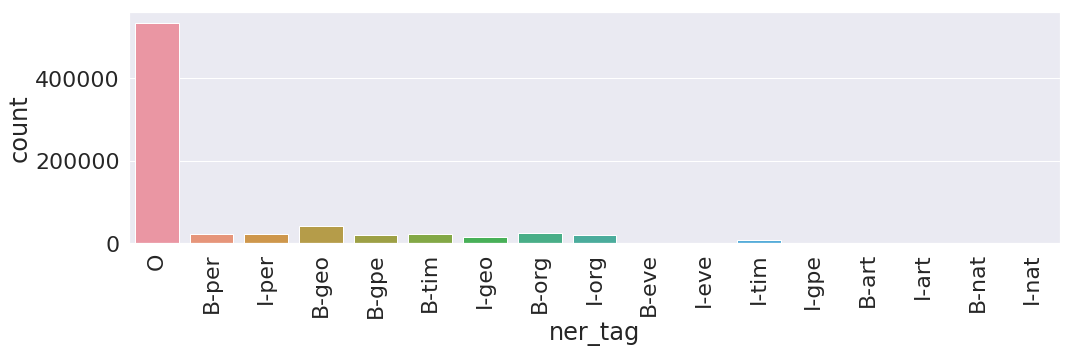

In [22]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd_f_add_f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [23]:
tagged_texts_as_pd_f_add_f.ner_tag.value_counts()

O        533756
B-geo     41788
B-org     22910
B-tim     22482
I-per     22429
B-per     20643
I-org     19555
B-gpe     19070
I-geo     13183
I-tim      5602
I-gpe       613
B-art       407
I-art       324
B-eve       310
I-eve       248
B-nat       208
I-nat        72
Name: ner_tag, dtype: int64

## Words distribution across sense numbers

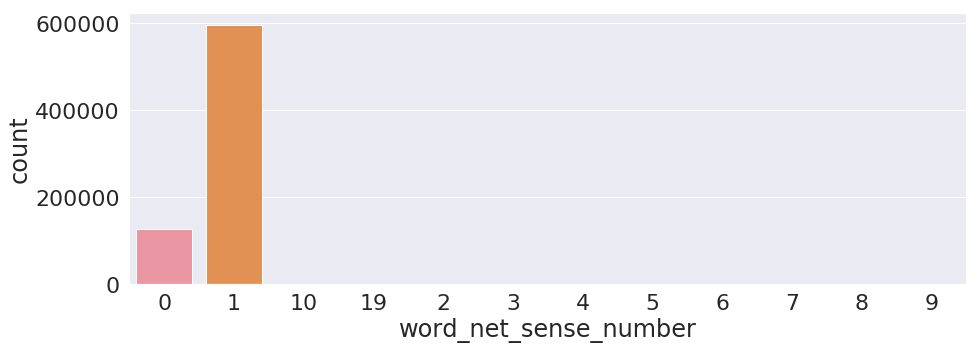

In [24]:
plt.figure(figsize=(15, 5))
sns.countplot('word_net_sense_number', data=tagged_texts_as_pd_f_add_f)
plt.show()

In [25]:
tagged_texts_as_pd_f_add_f.word_net_sense_number.value_counts()

1     595259
0     127591
2        445
3        180
4         65
5         34
6         10
8          5
7          4
9          4
10         2
19         1
Name: word_net_sense_number, dtype: int64

## Words distribution across POS-tags

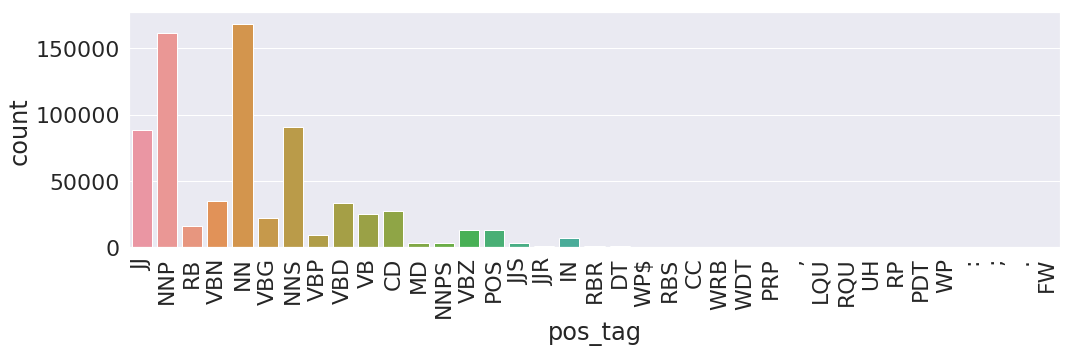

In [26]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('pos_tag', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [27]:
tagged_texts_as_pd_f_add_f.pos_tag.value_counts()

NN      168662
NNP     161497
NNS      90674
JJ       88206
VBN      34997
VBD      33454
CD       27154
VB       25093
VBG      21838
RB       15989
POS      13310
VBZ      13154
VBP       9207
IN        7333
JJS       3237
NNPS      3218
MD        3208
DT        1098
JJR       1067
RBR        868
WP$        104
RP          67
PDT         37
CC          34
PRP         16
;           12
UH          10
:           10
RQU          9
RBS          9
LQU          8
WDT          8
WP           4
,            3
.            2
WRB          2
FW           1
Name: pos_tag, dtype: int64

## Words distribution across semantic relation prepositions

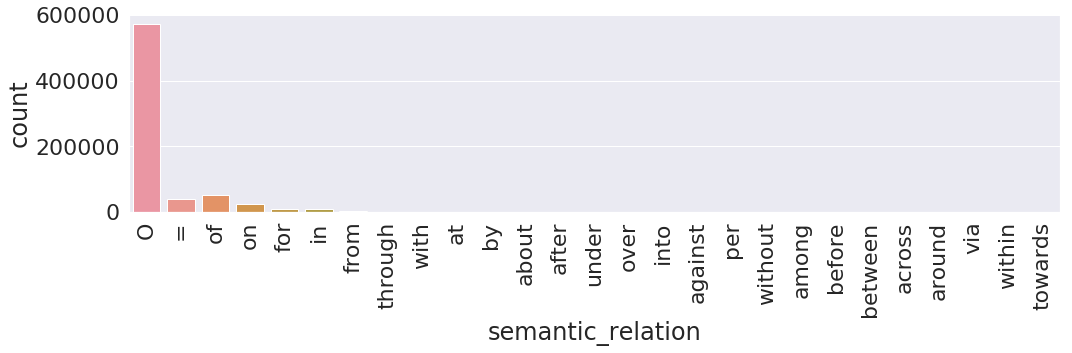

In [28]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('semantic_relation', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [29]:
tagged_texts_as_pd_f_add_f.semantic_relation.value_counts()

O          573387
of          53652
=           41537
on          25817
in          10634
for          8641
from         3124
with         1874
by           1656
at           1297
under         425
about         283
without       256
after         204
against       192
into          161
over          155
between        65
per            51
through        50
before         46
via            31
around         30
among          15
across         11
within          4
towards         2
Name: semantic_relation, dtype: int64

## Words distribution across animacy-tags

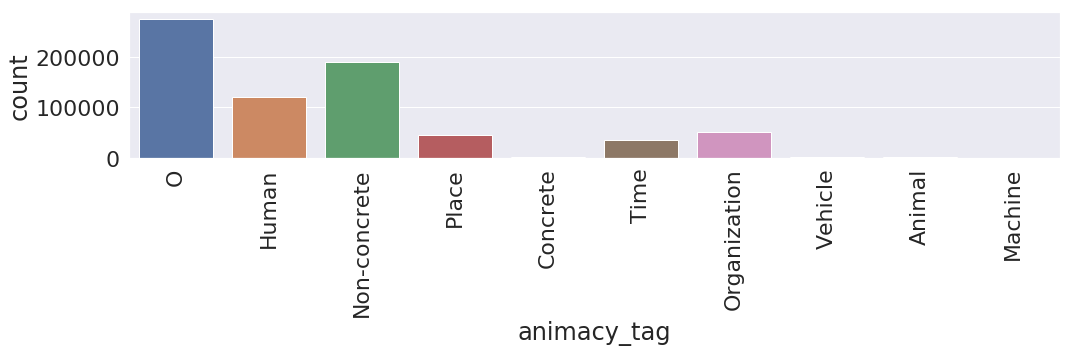

In [30]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('animacy_tag', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [31]:
tagged_texts_as_pd_f_add_f.animacy_tag.value_counts()

O               274501
Non-concrete    190887
Human           120663
Organization     50513
Place            46092
Time             35542
Concrete          2594
Animal            1572
Vehicle           1230
Machine              6
Name: animacy_tag, dtype: int64

# Words distributions (separated by each NER-tag)

## Words distribution across sense numbers

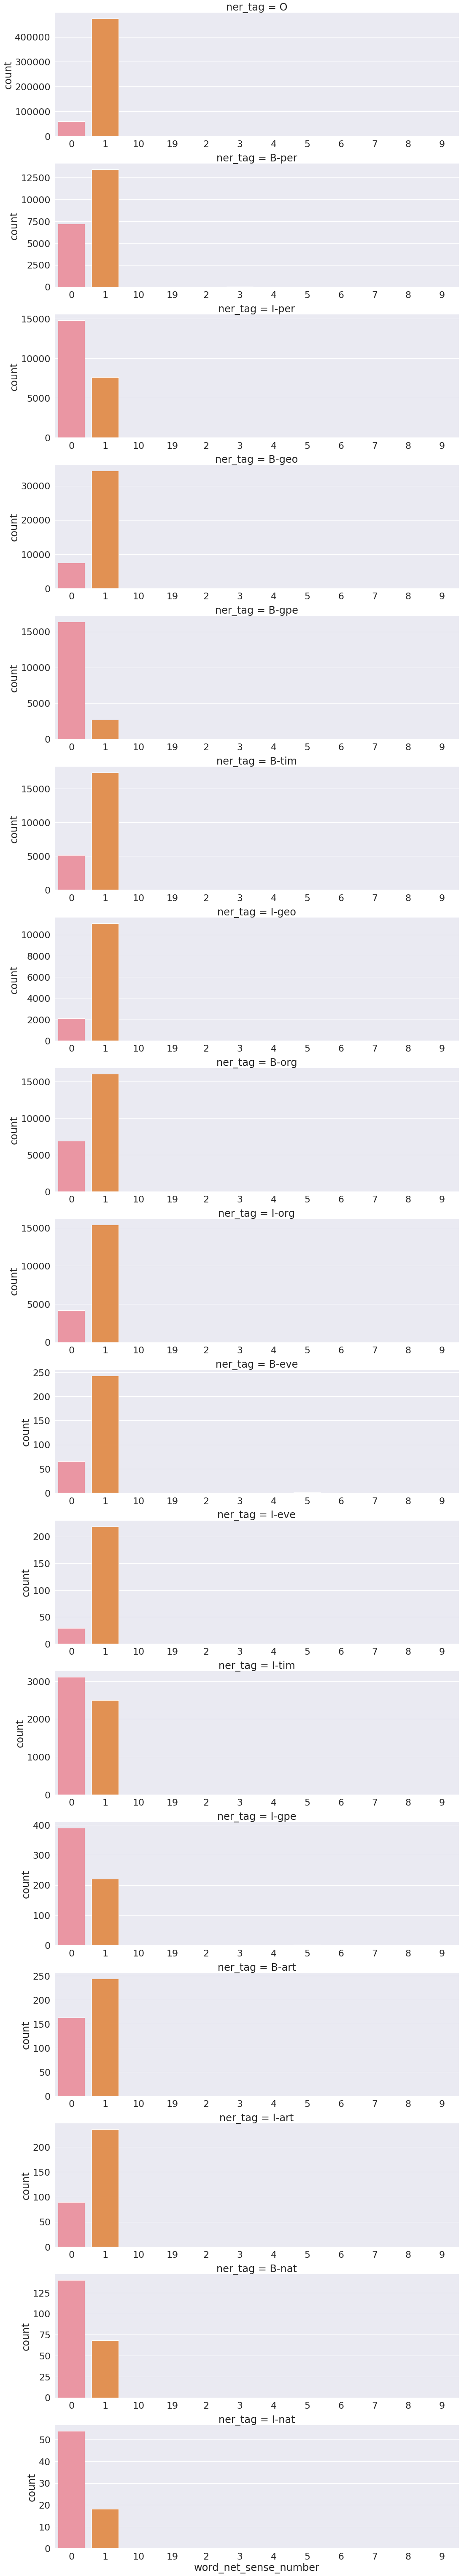

In [32]:
sns.catplot(
    'word_net_sense_number',
    col='ner_tag',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    orient='h',
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
plt.show()

## Words distribution across POS-tags

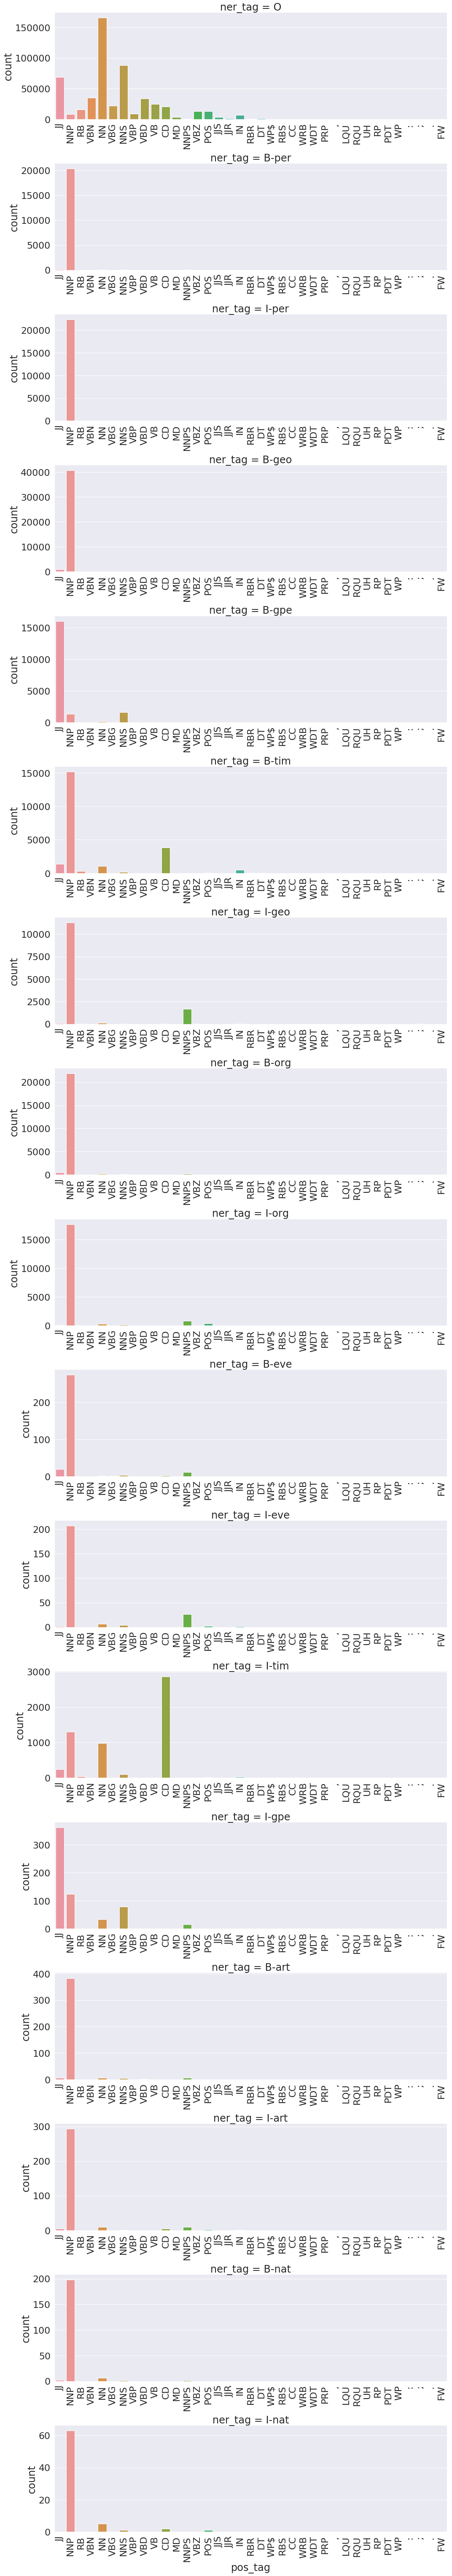

In [33]:
g = sns.catplot(
    'pos_tag',
    col='ner_tag',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    orient='h',
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across semantic relation prepositions

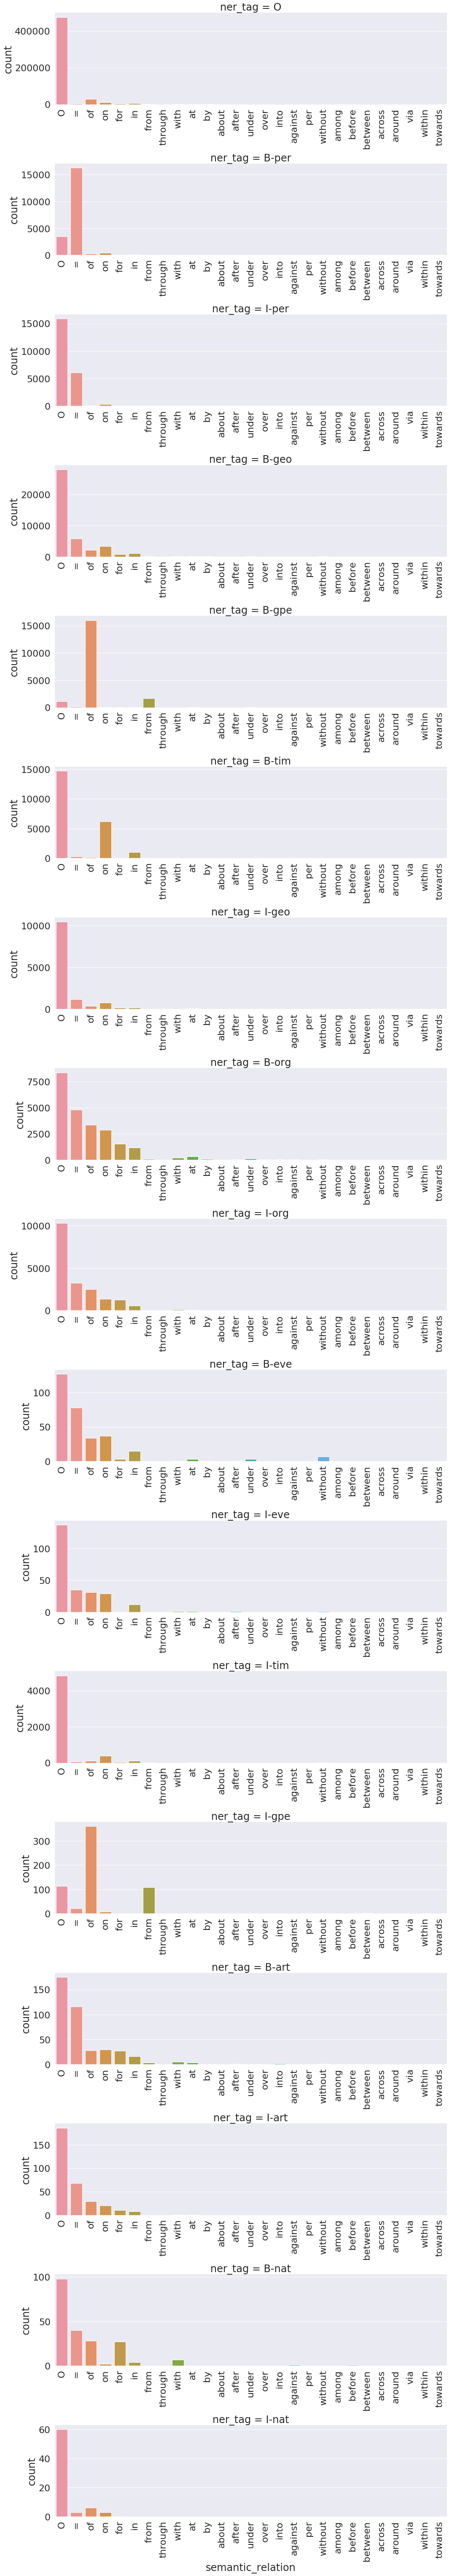

In [34]:
g = sns.catplot(
    'semantic_relation',
    col='ner_tag',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    orient='h',
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across animacy-tags

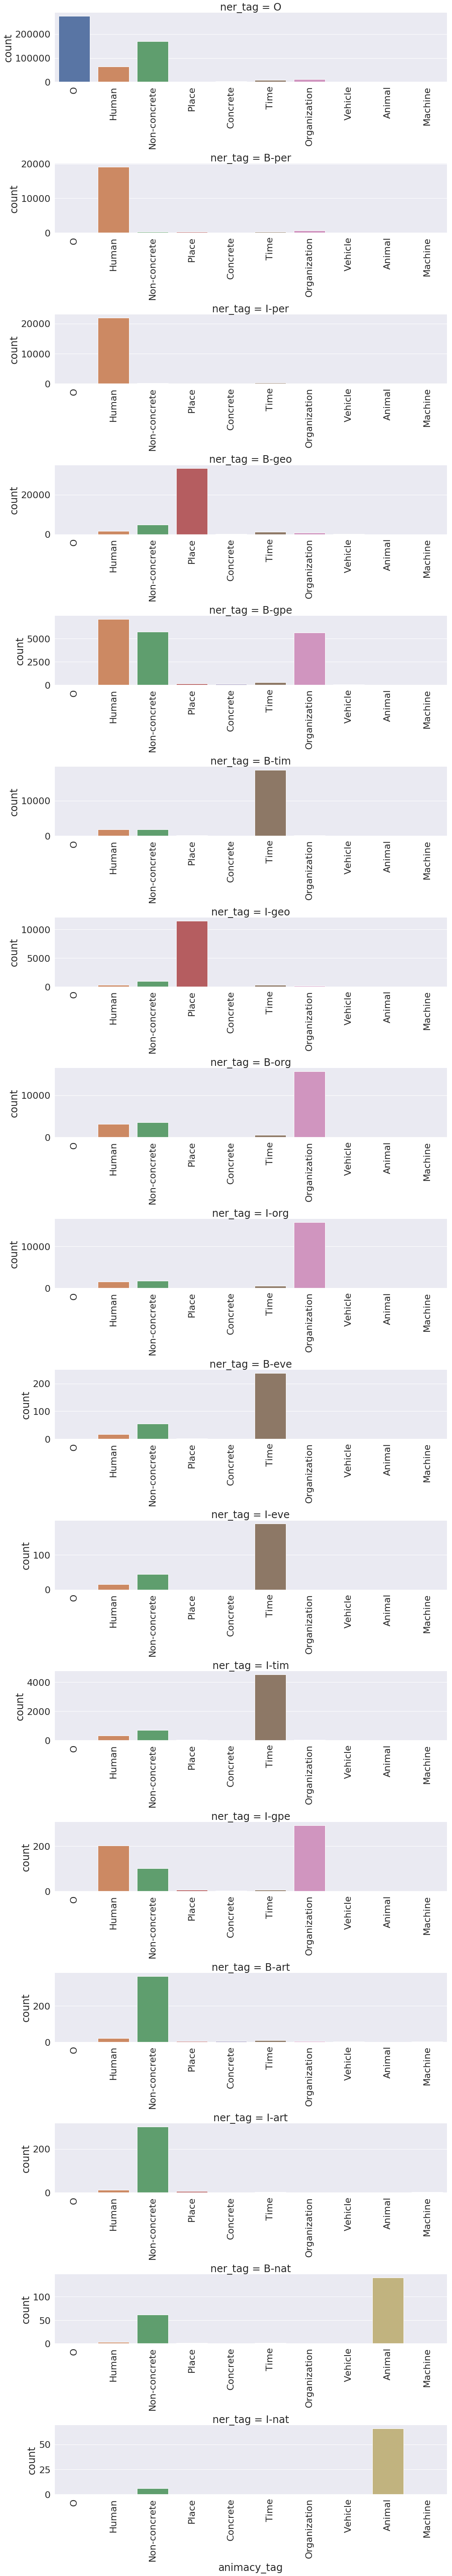

In [35]:
g = sns.catplot(
    'animacy_tag',
    col='ner_tag',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    orient='h',
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across word lengths

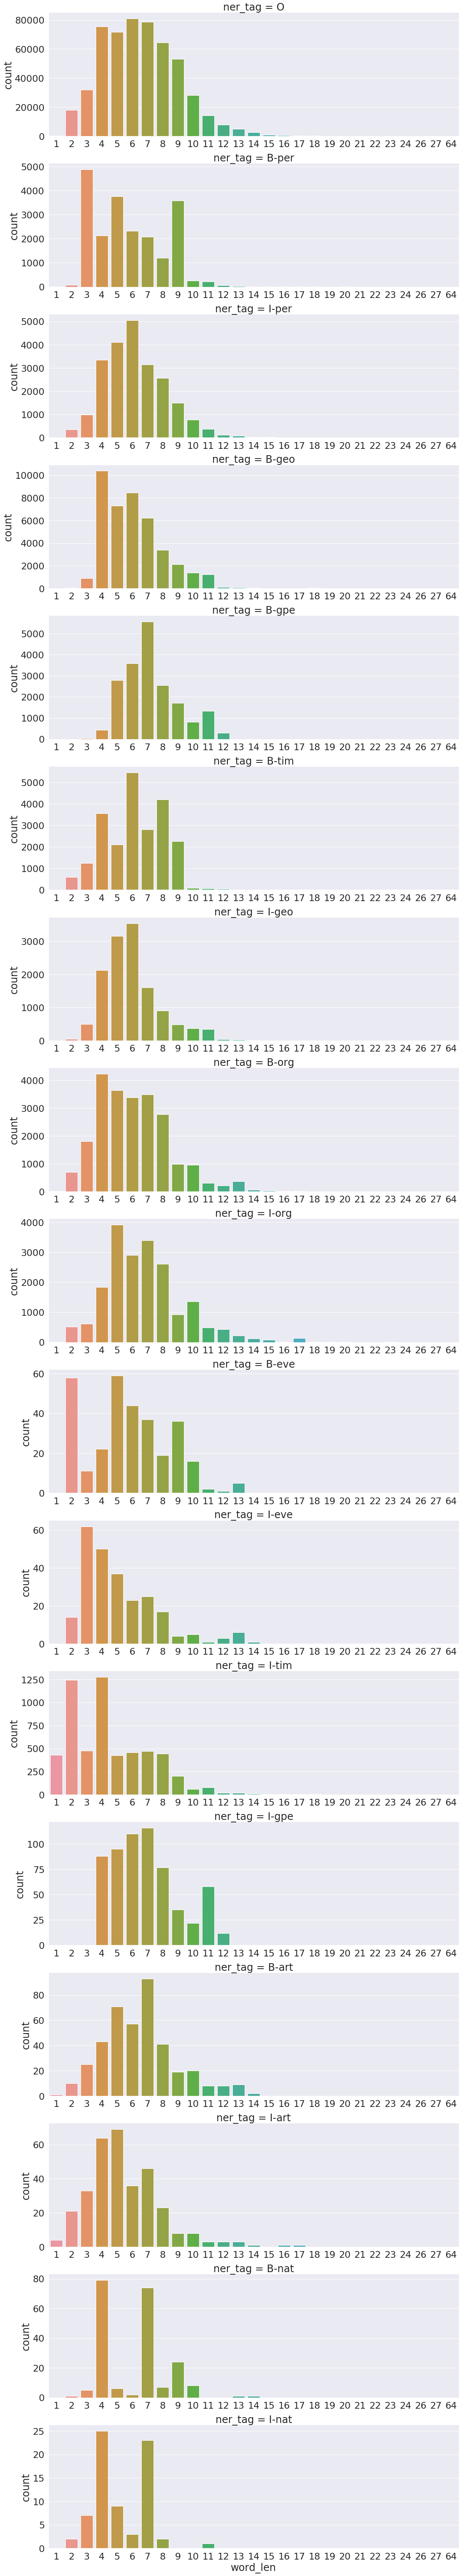

In [36]:
sns.catplot(
    'word_len',
    col='ner_tag',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    orient='h',
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
plt.show()

## Words distribution across semantic relation existence

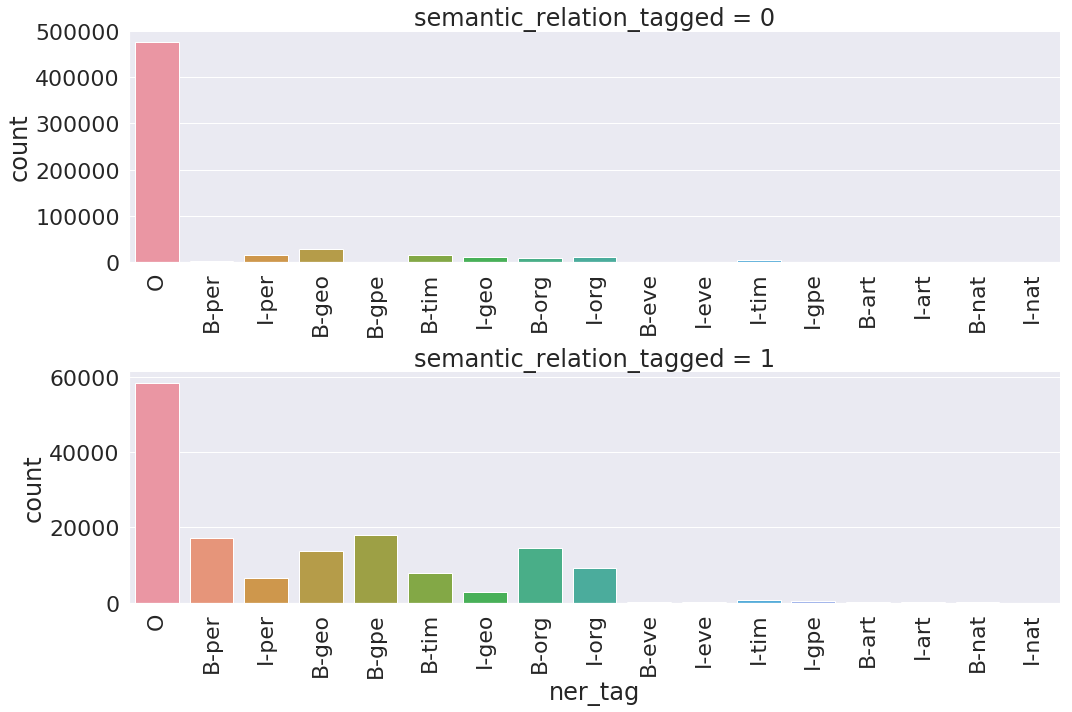

In [37]:
g = sns.catplot(
    'ner_tag',
    col='semantic_relation_tagged',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    orient='h',
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across animacy tag existence

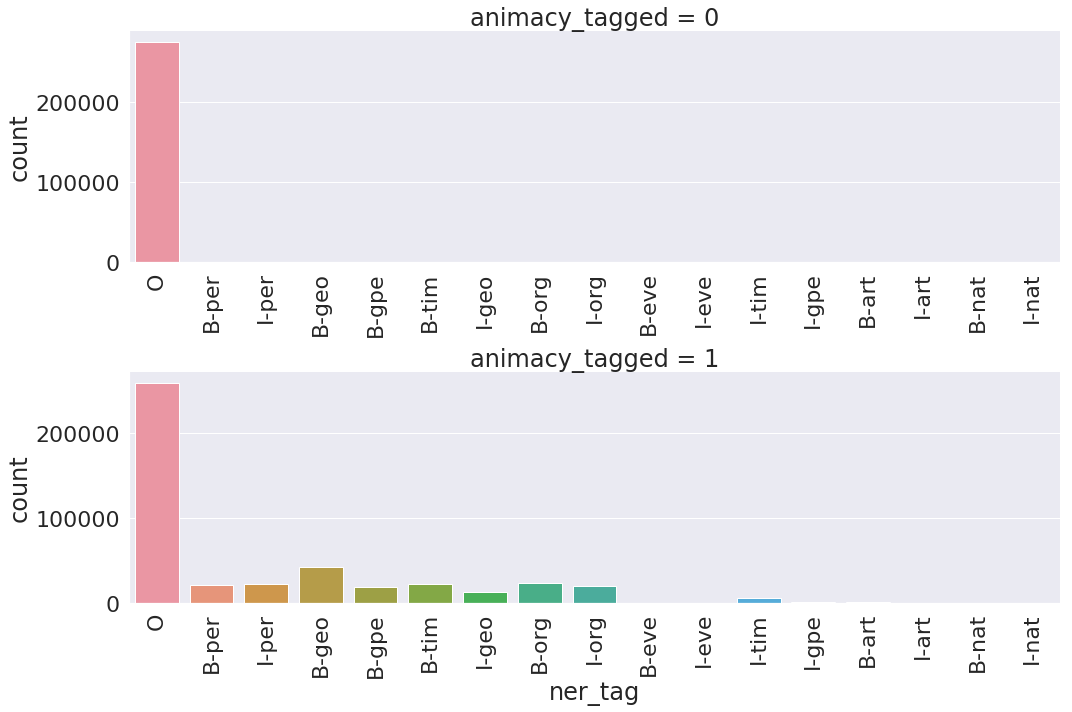

In [38]:
g = sns.catplot(
    'ner_tag',
    col='animacy_tagged',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    orient='h',
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across word sense existence

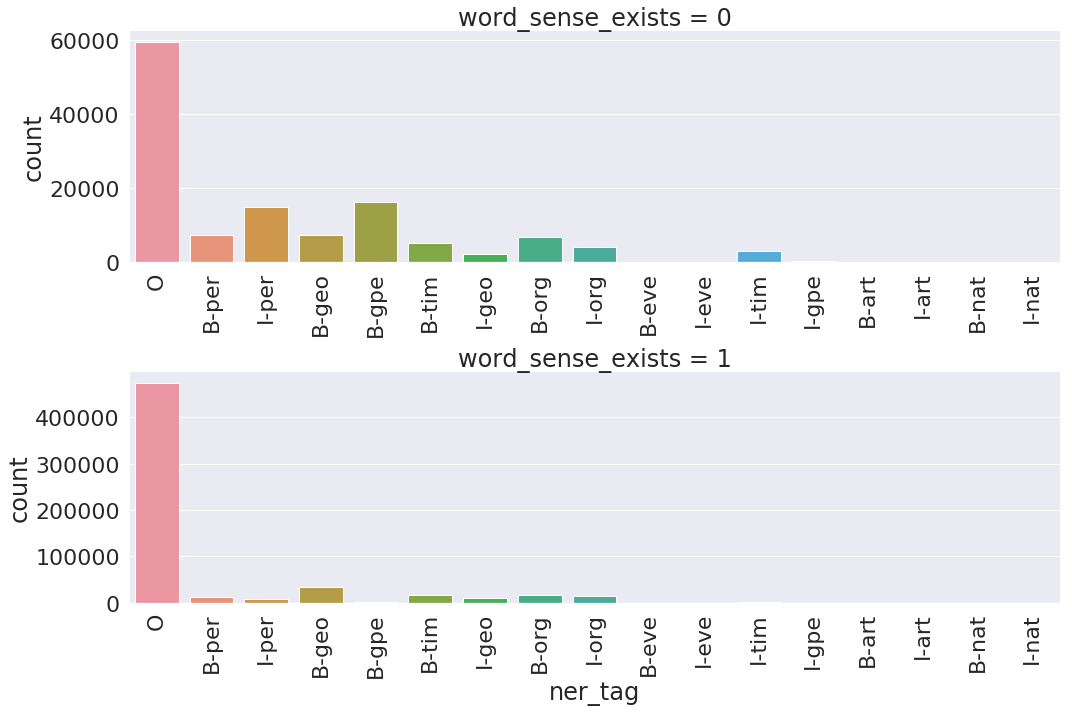

In [39]:
g = sns.catplot(
    'ner_tag',
    col='word_sense_exists',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across NER-tags (for titled and not titled words)

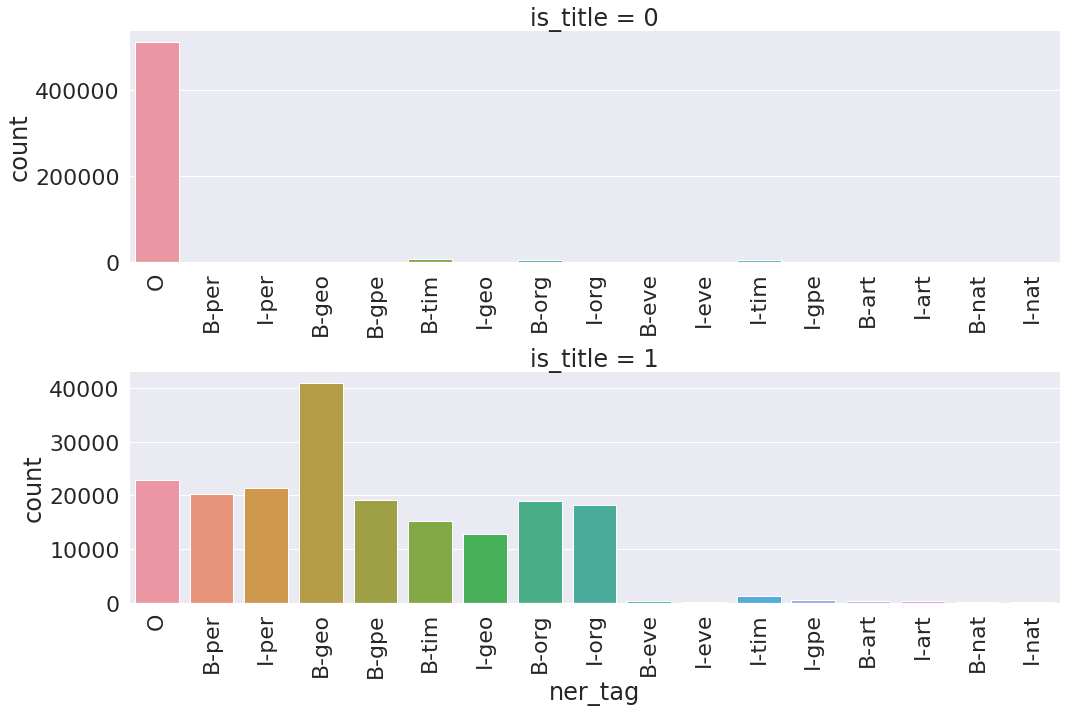

In [40]:
g = sns.catplot(
    'ner_tag',
    col='is_title',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Words distribution across NER-tags (for words with and without digits)

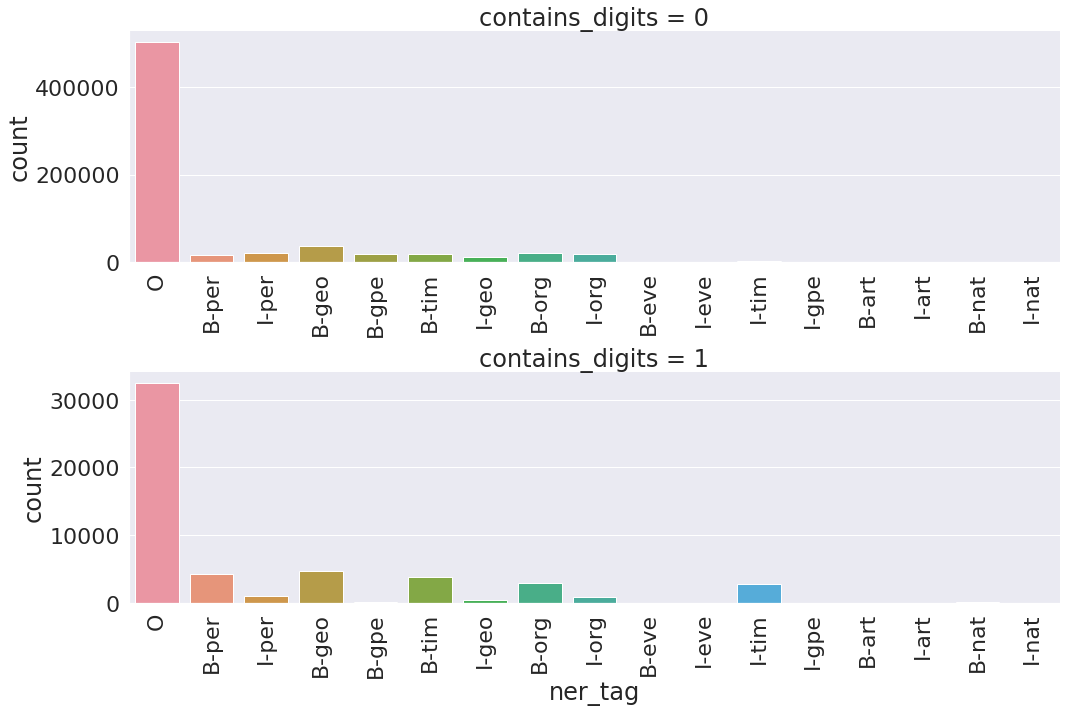

In [41]:
g = sns.catplot(
    'ner_tag',
    col='contains_digits',
    data=tagged_texts_as_pd_f_add_f,
    kind="count",
    col_wrap=1,
    sharex=False,
    sharey=False,
    aspect=3
)
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Distribution of lambda-DSR mean lengths across NER-tags

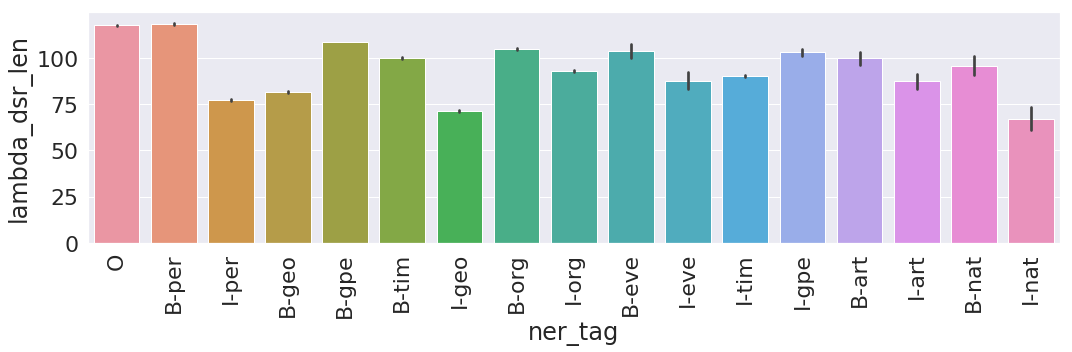

In [42]:
plt.figure(figsize=(15, 5))
ax = sns.barplot("ner_tag", "lambda_dsr_len", data=tagged_texts_as_pd_f_add_f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Distribution of word mean lengths across NER-tags

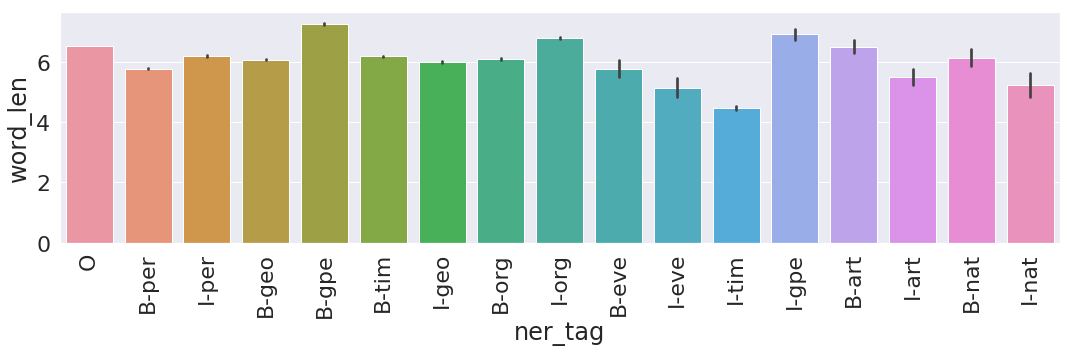

In [43]:
plt.figure(figsize=(15, 5))
ax = sns.barplot("ner_tag", "word_len", data=tagged_texts_as_pd_f_add_f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Conclusion